<a href="https://colab.research.google.com/github/HyunMiPark/study_AI/blob/main/%5B5%EC%A3%BC%EC%B0%A8%5D_%EC%8B%AC%ED%99%94%EA%B3%BC%EC%A0%9C_%EB%85%BC%EB%AC%B8%20%EC%9A%94%EC%95%BD%20LLM%20%EC%84%9C%EB%B9%84%EC%8A%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langchain-community langchain-chroma langchain-openai pypdf
!pip install langchain langchain-community
!pip install pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.3/302.3 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 42.6 MB/s eta 0:00:00


In [3]:
import bs4
import os
from getpass import getpass
from langchain import hub
from langchain_chroma import Chroma
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from google.colab import files

In [4]:
# ✅ 키 입력 받아 환경변수로 저장
os.environ["OPENAI_API_KEY"] = getpass("🔑 Enter your OpenAI API key: ")

llm = ChatOpenAI(model="gpt-4o-mini", openai_api_key=os.environ["OPENAI_API_KEY"])

🔑 Enter your OpenAI API key: ··········


In [8]:
#파일 업로드
uploaded = files.upload()

Saving 2005.11401v4.pdf to 2005.11401v4.pdf


In [10]:
loader = PyPDFLoader("2005.11401v4.pdf")
docs = loader.load()
#긴 텍스트를 길이 1000자, 중첩 200자 단위로 분할
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
#나눠진 텍스트 조각을 OpenAI Embedding을 이용해 벡터 저장소에 저장
vectorstore = Chroma.from_documents(
    documents=splits,
    embedding=OpenAIEmbeddings(api_key=os.environ["OPENAI_API_KEY"])
)

In [11]:
#해당 벡터스토어에서 유사 문서 검색 가능한 retriever로 변환
retriever = vectorstore.as_retriever()

#사용자가 입력한 질문(user_msg)과 가장 유사한 문서들(top-k)을 검색
user_msg = "Given the PDF file of the research paper which the title is 'Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks', please provide me the summary of the paper."
retrieved_docs = retriever.invoke(user_msg)

#검색된 문서들을 하나의 긴 문자열(context)로 묶음
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)
#LangChain Hub에서 미리 정의된 RAG용 프롬프트 템플릿을 불러옴
prompt = hub.pull("rlm/rag-prompt")

#템플릿에 context + question을 넣어 LLM이 처리할 입력 프롬프트 생성
user_prompt = prompt.invoke({"context": format_docs(retrieved_docs), "question": user_msg})
#ChatGPT(OpenAI LLM)을 호출하여 최종 답변 생성
response = llm.invoke(user_prompt)

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:271: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [12]:
response

AIMessage(content='The paper discusses the limitations of large pre-trained language models in accessing and manipulating knowledge, particularly in knowledge-intensive NLP tasks. It proposes a Retrieval-Augmented Generation (RAG) framework that combines retrieval mechanisms with generative capabilities to improve performance on these tasks. The study highlights the potential of RAG to provide more accurate and up-to-date information by leveraging external knowledge sources.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 75, 'prompt_tokens': 749, 'total_tokens': 824, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_dbaca60df0', 'id': 'chatcmpl-BSHk2M9v8NrKWam296pUzs4LTpvwl', 'finish_reason': 'stop', 'logprobs': None}, i

In [14]:
for i, doc in enumerate(retrieved_docs):
    print(f"\n--- Doc {i+1} ---\n")
    print(doc.page_content[:500])  # 앞부분만 출력

print(user_prompt)


--- Doc 1 ---

Retrieval-Augmented Generation for
Knowledge-Intensive NLP Tasks
Patrick Lewis†‡, Ethan Perez⋆,
Aleksandra Piktus†, Fabio Petroni†, Vladimir Karpukhin†, Naman Goyal†, Heinrich Küttler†,
Mike Lewis†, Wen-tau Yih†, Tim Rocktäschel†‡, Sebastian Riedel†‡, Douwe Kiela†
†Facebook AI Research; ‡University College London; ⋆New York University;
plewis@fb.com
Abstract
Large pre-trained language models have been shown to store factual knowledge
in their parameters, and achieve state-of-the-art results when

--- Doc 2 ---

Appendices for Retrieval-Augmented Generation for
Knowledge-Intensive NLP Tasks
A Implementation Details
For Open-domain QA we report test numbers using 15 retrieved documents for RAG-Token models.
For RAG-Sequence models, we report test results using 50 retrieved documents, and we use the
Thorough Decoding approach since answers are generally short. We use greedy decoding for QA as
we did not ﬁnd beam search improved results. For Open-MSMarco and Jeopardy questi

검색된 문서 유사도 점수 시각화
* Chroma에서 similarity_search_with_score() 를 사용하면, 사용자 질문과 문서 간의 유사도 점수를 함께 확인 가능
* 점수가 낮을수록(예: 0.45) 유사도가 높다는 뜻 (Chroma는 cosine distance 기준).


In [15]:
docs_with_scores = vectorstore.similarity_search_with_score(user_msg, k=5)

import pandas as pd
df = pd.DataFrame([{
    "Index": i+1,
    "Score": round(score, 4),
    "Preview": doc.page_content[:200].replace("\n", " ") + "..."
} for i, (doc, score) in enumerate(docs_with_scores)])

from IPython.display import display
display(df)

,Index,Score,Preview
0,1,0.3303,Retrieval-Augmented Generation for Knowledge-I...
1,2,0.3587,Appendices for Retrieval-Augmented Generation ...
2,3,0.3652,text generation. To test RAG’s natural languag...
3,4,0.3668,https://www.aclweb.org/anthology/P17-1171. [6]...
4,5,0.3689,"[20] Kelvin Guu, Kenton Lee, Zora Tung, Panupo..."


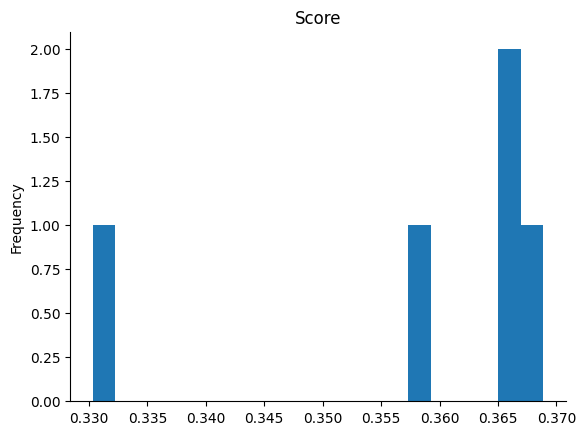

In [16]:
# @title Score

from matplotlib import pyplot as plt
df['Score'].plot(kind='hist', bins=20, title='Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

요약 vs 원문 비교 (RAG 결과 검증용)

In [17]:
print("📌 요약 결과:")
print(response.content)

print("\n📄 원문 문서 Top-3:")
for i, doc in enumerate(retrieved_docs[:3]):
    print(f"\n--- Doc {i+1} ---")
    print(doc.page_content[:500])  # 앞부분만 출력

📌 요약 결과:
The paper discusses the limitations of large pre-trained language models in accessing and manipulating knowledge, particularly in knowledge-intensive NLP tasks. It proposes a Retrieval-Augmented Generation (RAG) framework that combines retrieval mechanisms with generative capabilities to improve performance on these tasks. The study highlights the potential of RAG to provide more accurate and up-to-date information by leveraging external knowledge sources.

📄 원문 문서 Top-3:

--- Doc 1 ---
Retrieval-Augmented Generation for
Knowledge-Intensive NLP Tasks
Patrick Lewis†‡, Ethan Perez⋆,
Aleksandra Piktus†, Fabio Petroni†, Vladimir Karpukhin†, Naman Goyal†, Heinrich Küttler†,
Mike Lewis†, Wen-tau Yih†, Tim Rocktäschel†‡, Sebastian Riedel†‡, Douwe Kiela†
†Facebook AI Research; ‡University College London; ⋆New York University;
plewis@fb.com
Abstract
Large pre-trained language models have been shown to store factual knowledge
in their parameters, and achieve state-of-the-art results whe

PDF 전체 내용을 Table로 정리하는 방법
* 목표: PDF 내 텍스트를 섹션별(제목, 내용 등)로 테이블 구조로 정리

In [18]:
# PyPDFLoader로 불러온 문서
docs = loader.load()

table_data = []
for i, doc in enumerate(docs):
    table_data.append({
        "Page": i+1,
        "Content": doc.page_content[:500] + "..."  # 앞부분만 보기
    })

pdf_df = pd.DataFrame(table_data)
display(pdf_df)

,Page,Content
0,1,Retrieval-Augmented Generation for\nKnowledge-...
1,2,The\tDivine\nComedy\t(x) q \nQuery \nEncoder \...
2,3,by θthat generates a current token based on a ...
3,4,minimize the negative marginal log-likelihood ...
4,5,MSMARCO as an open-domain abstractive QA task....
5,6,"Table 1: Open-Domain QA Test Scores. For TQA,\..."
6,7,Document 1: his works are considered classics ...
7,8,Table 4: Human assessments for the Jeopardy\nQ...
8,9,General-Purpose Architectures for NLP Prior wo...
9,10,Broader Impact\nThis work offers several posit...


In [19]:
import re

# "Abstract", "Introduction", "Method", "Conclusion" 등 섹션 제목 기준으로 나누기
sections = re.split(r'\n(?=[A-Z][a-zA-Z ]{2,}\n)', docs[0].page_content)

for i, section in enumerate(sections[:5]):
    print(f"\n--- Section {i+1} ---\n")
    print(section[:500])


--- Section 1 ---

Retrieval-Augmented Generation for
Knowledge-Intensive NLP Tasks
Patrick Lewis†‡, Ethan Perez⋆,
Aleksandra Piktus†, Fabio Petroni†, Vladimir Karpukhin†, Naman Goyal†, Heinrich Küttler†,
Mike Lewis†, Wen-tau Yih†, Tim Rocktäschel†‡, Sebastian Riedel†‡, Douwe Kiela†
†Facebook AI Research; ‡University College London; ⋆New York University;
plewis@fb.com

--- Section 2 ---

Abstract
Large pre-trained language models have been shown to store factual knowledge
in their parameters, and achieve state-of-the-art results when ﬁne-tuned on down-
stream NLP tasks. However, their ability to access and precisely manipulate knowl-
edge is still limited, and hence on knowledge-intensive tasks, their performance
lags behind task-speciﬁc architectures. Additionally, providing provenance for their
decisions and updating their world knowledge remain open research problems. Pre-
tr
